### Нейронная сеть для классификации

In [1]:
datasets = [
    "../my_datasets/cat_tnsum_5.csv",
    "../my_datasets/cat_tnsum_13.csv",
    "../my_datasets/cat_tnsum_23.csv",
    "../my_datasets/cat_tnsum_43.csv",
    "../my_datasets/cat_tnsum_53.csv",
    "../my_datasets/cat_tnsum_103.csv"
]

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv(datasets[0], index_col=0)
print("Строк:", len(data))
print("Столбцов:", len(data.columns))

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(["labels", "text"], axis=1), 
    data["labels"], 
    test_size=0.2
)

Строк: 111377
Столбцов: 5


In [3]:
import numpy as np

y = data["labels"]
pos_class_weight = (len(y) - np.sum(y)) / np.sum(y)

pos = np.sum(y)  # Положительные примеры
neg = len(y) - pos
total = len(y)

weight_for_0 = (1 / neg) * (total / 2.0)  # Вес для класса 0
weight_for_1 = (1 / pos) * (total / 2.0)  # Вес для класса 1

class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.6031267260892639), 1: np.float64(2.9242018483511867)}


In [4]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.3)  # Частичное oversampling
X_res, y_res = smote.fit_resample(X_train, y_train)

In [5]:
from keras import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.metrics import AUC

# Увеличение скрытых слоев и регуляризация
model = Sequential()
model.add(Input((X_train.shape[1],)))

# Слой 1 с регуляризацией
model.add(Dense(256, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Слой 2
model.add(Dense(128, activation="elu"))  # ELU лучше для глубоких сетей
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Слой 3 (меньший размер)
model.add(Dense(64, activation="elu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Выходной слой
model.add(Dense(1, activation="sigmoid"))

# Метрика PR-AUC
pr_auc = AUC(name='pr_auc', curve='PR')

# Компиляция с class weighting
model.compile(
    metrics=[pr_auc, "AUC"],  # PR-AUC + ROC-AUC
    loss="binary_crossentropy",
    optimizer="adam"
)
model.summary()

2025-06-26 00:02:52.931869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 00:02:53.241552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750885373.355002  126727 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750885373.384715  126727 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750885373.689303  126727 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,033 (172.00 KB)

 Trainable params: 43,137 (168.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
]

history = model.fit(
    X_res, y_res,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,  # Передача весов
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - AUC: 0.6675 - loss: 0.7568 - pr_auc: 0.3399 - val_AUC: 0.7400 - val_loss: 0.6526 - val_pr_auc: 0.3405 - learning_rate: 0.0010
Epoch 2/100
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - AUC: 0.7231 - loss: 0.6680 - pr_auc: 0.3931 - val_AUC: 0.7344 - val_loss: 0.7734 - val_pr_auc: 0.3375 - learning_rate: 0.0010
Epoch 3/100
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.7270 - loss: 0.6655 - pr_auc: 0.3983 - val_AUC: 0.7387 - val_loss: 0.6733 - val_pr_auc: 0.3401 - learning_rate: 0.0010
Epoch 4/100
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.7281 - loss: 0.6631 - pr_auc: 0.4037 - val_AUC: 0.7370 - val_loss: 0.6145 - val_pr_auc: 0.3404 - learning_rate: 0.0010
Epoch 5/100
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - AUC: 0.7286 - loss: 0.6670 - pr_auc: 0.4056 - val_AUC: 0.7396 - val_loss: 0.6459 - val_pr_auc: 0.3428 - learning_rate: 0.0010
Epoch 6/100
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.7315 - loss: 0.6

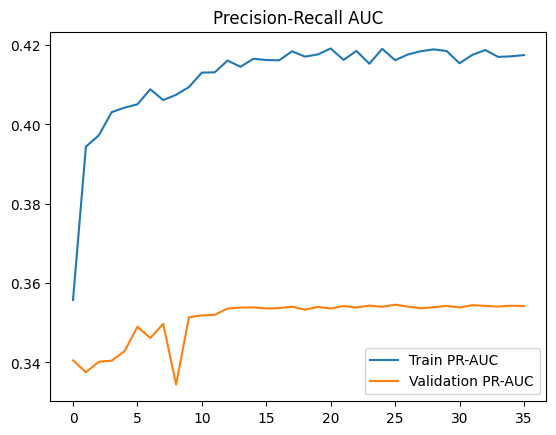

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['pr_auc'], label='Train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Validation PR-AUC')
plt.title('Precision-Recall AUC')
plt.legend()
plt.show()


697/697 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
PR-AUC 0.24607186487765298
ROC-AUC 0.6768618683904183
Точность:  0.25798583792289537
Полнота:  0.8640316205533597


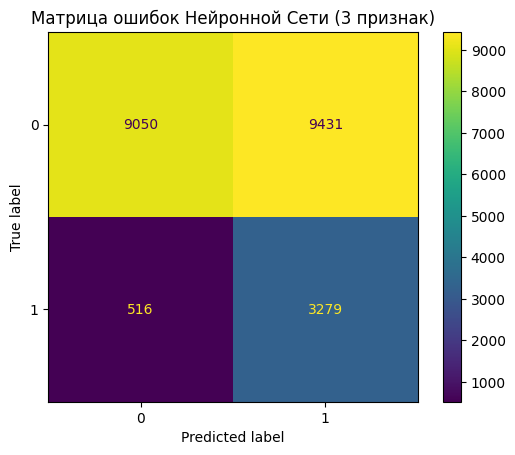

In [8]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

y_pred = (model.predict(X_test) > 0.5)


print("PR-AUC", average_precision_score(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, y_pred))
print("Точность: ", precision_score(y_test, y_pred))
print("Полнота: ", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Матрица ошибок Нейронной Сети ({X_test.shape[1]} признак)")
plt.show()

In [10]:
text = 'МОСКВА, 25 июня. /ТАСС/. Авиакомпании вынужденно корректируют расписание рейсов в связи с тем, что в пяти городах Приволжского федерального округа приостановлена работа аэропортов. Об этом сообщила Росавиация. "В связи с временной приостановкой полетов в ряде аэропортов Приволжского федерального округа в среду, 25 июня, авиакомпании продолжают вынужденную корректировку расписания полетов", - говорится в сообщении. В агентстве уточнили, что аэропорты в Казани, Нижнекамске (Бегишево), Пензе, Самаре (Курумоч) и Ульяновске (Баратаевка) не отправляют и не принимают рейсы. Представители перевозчиков работают с пассажирами задержанных рейсов. Как передает Росавиация информацию Приволжского межрегионального территориального управления ведомства, в аэропортах обстановка спокойная. Аэропорты готовы усилить смены для обеспечения оперативного выпуска самолетов после возобновления работы.'

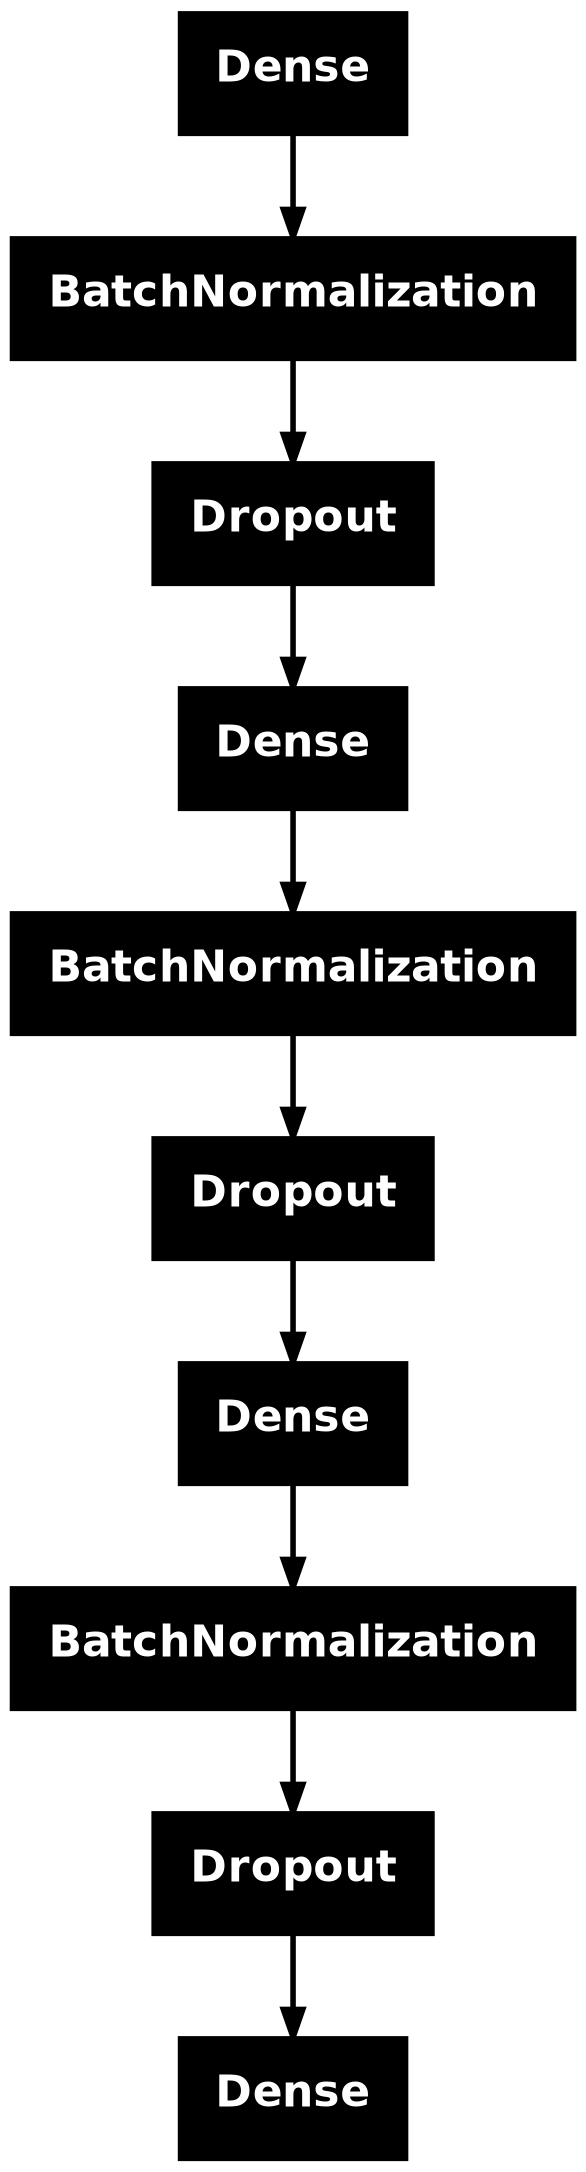

In [8]:
from keras.utils import plot_model

plot_model(model)